Chapter 5 基本的な回帰とモデルのチェック
=====
---

## 5.1. 重回帰
データの分布の確認：散布図行列

In [6]:
# fig5-1.R
library(ggplot2)
library(GGally)

set.seed(123)
d <- read.csv(file='input/data-attendance-1.txt')
d$A <- as.factor(d$A)

N_col <- ncol(d)
ggp <- ggpairs(d, upper='blank', diag='blank', lower='blank')

for(i in 1:N_col) {
  x <- d[,i]
  p <- ggplot(data.frame(x, A=d$A), aes(x))
  p <- p + theme_bw(base_size=14)
  p <- p + theme(axis.text.x=element_text(angle=40, vjust=1, hjust=1))
  if (class(x) == 'factor') {
    p <- p + geom_bar(aes(fill=A), color='grey5')
  } else {
    bw <- (max(x)-min(x))/10
    p <- p + geom_histogram(binwidth=bw, aes(fill=A), color='grey5')
    p <- p + geom_line(eval(bquote(aes(y=..count..*.(bw)))), stat='density')
  }
  p <- p + geom_label(data=data.frame(x=-Inf, y=Inf, label=colnames(d)[i]), aes(x=x, y=y, label=label), hjust=0, vjust=1)
  p <- p + scale_fill_manual(values=alpha(c('white', 'grey40'), 0.5))
  ggp <- putPlot(ggp, p, i, i)
}

zcolat <- seq(-1, 1, length=81)
zcolre <- c(zcolat[1:40]+1, rev(zcolat[41:81]))

for(i in 1:(N_col-1)) {
  for(j in (i+1):N_col) {
    x <- as.numeric(d[,i])
    y <- as.numeric(d[,j])
    r <- cor(x, y, method='spearman', use='pairwise.complete.obs')
    zcol <- lattice::level.colors(r, at=zcolat, col.regions=grey(zcolre))
    textcol <- ifelse(abs(r) < 0.4, 'grey20', 'white')
    ell <- ellipse::ellipse(r, level=0.95, type='l', npoints=50, scale=c(.2, .2), centre=c(.5, .5))
    p <- ggplot(data.frame(ell), aes(x=x, y=y))
    p <- p + theme_bw() + theme(
      plot.background=element_blank(),
      panel.grid.major=element_blank(), panel.grid.minor=element_blank(),
      panel.border=element_blank(), axis.ticks=element_blank()
    )
    p <- p + geom_polygon(fill=zcol, color=zcol)
    p <- p + geom_text(data=NULL, x=.5, y=.5, label=100*round(r, 2), size=6, col=textcol)
    ggp <- putPlot(ggp, p, i, j)
  }
}

for(j in 1:(N_col-1)) {
  for(i in (j+1):N_col) {
    x <- d[,j]
    y <- d[,i]
    p <- ggplot(data.frame(x, y, gr=d$A), aes(x=x, y=y, fill=gr, shape=gr))
    p <- p + theme_bw(base_size=14)
    p <- p + theme(axis.text.x=element_text(angle=40, vjust=1, hjust=1))
    if (class(x) == 'factor') {
      p <- p + geom_boxplot(aes(group=x), alpha=3/6, outlier.size=0, fill='white')
      p <- p + geom_point(position=position_jitter(w=0.4, h=0), size=2)
    } else {
      p <- p + geom_point(size=2)
    }
    p <- p + scale_shape_manual(values=c(21, 24))
    p <- p + scale_fill_manual(values=alpha(c('white', 'grey40'), 0.5))
    ggp <- putPlot(ggp, p, i, j)
  }
}

png(file='output/fig5-1.png', w=1600, h=1600, res=300)
print(ggp, left=0.3, bottom=0.3)
dev.off()

pdf 
  2

<img width="500" src="output/fig5-1.png"></img>

### データのスケーリング
stanコードを実行する。

scoreは200で割って0-1にスケーリングしてある。その他、
- 単位が万円なら万で割る
- 標準偏差で割る
- 標準偏差の2倍で割る
- データの最大値で割る

など

In [8]:
# run-model5-3.R
library(rstan)

d <- read.csv(file='input/data-attendance-1.txt')
data <- list(N=nrow(d), A=d$A, Score=d$Score/200, Y=d$Y) # scoreを0-1にnormalize してある
fit <- stan(file='model/model5-3.stan', data=data, seed=1234)

save.image('output/result-model5-3.RData')

Loading required package: StanHeaders
rstan (Version 2.16.2, packaged: 2017-07-03 09:24:58 UTC, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())


In file included from file2366d0563d8.cpp:8:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/src/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/stan/math.hpp:4:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/stan/math/rev/mat.hpp:4:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/stan/math/rev/core.hpp:12:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/stan/math/rev/core/gevv_vvv_vari.hpp:5:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/stan/math/rev/core/var.hpp:7:
In file included from /usr/local/lib/R/3.4/site-library/BH/include/boost/math/tools/config.hpp:13:
In file included from /usr/local/lib/R/3.4/site-library/BH/include/boost/config.hpp:39:
/usr/local/lib/R/3.4/site-library/BH/include/boost/config/compiler/clang.hpp:200:11: warning: 'BOOST_NO_CXX11_RVALUE_REFERENCES' macro red

In [11]:
summary(fit)$summary

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
b1,0.1237080,0.0007915784,0.032685289,0.05933963,0.10131048,0.1239283,0.14516324,0.18964909,1704.970,1.0032420
b2,-0.1433621,0.0003232118,0.015694059,-0.17505770,-0.15367413,-0.1431573,-0.13317507,-0.11248439,2357.741,1.0001956
b3,0.3240060,0.0012386221,0.051580536,0.22089021,0.28908222,0.3236569,0.35965052,0.42358951,1734.180,1.0025950
sigma,0.0516997,0.0001187241,0.005395079,0.04236225,0.04792176,0.0512334,0.05503906,0.06370667,2064.989,1.0003418
mu[1],0.2354901,0.0003861845,0.016501949,0.20202219,0.22450722,0.2355664,0.24606147,0.26811360,1825.916,1.0032574
mu[2],0.2152503,0.0002593830,0.013154803,0.18944968,0.20638499,0.2150494,0.22406324,0.24096509,2572.086,0.9999335
mu[3],0.3262118,0.0001724294,0.009584921,0.30721138,0.31972165,0.3263144,0.33253059,0.34525928,3089.972,1.0000558
mu[4],0.1196685,0.0003122104,0.015220434,0.08916001,0.10962018,0.1195094,0.12964263,0.14919250,2376.617,1.0019151
mu[5],0.2363107,0.0003082096,0.014912782,0.20688353,0.22632444,0.2363880,0.24625088,0.26607367,2341.127,1.0002225
mu[6],0.3391720,0.0001799859,0.010007403,0.31926149,0.33260343,0.3392231,0.34570336,0.35904595,3091.474,0.9996781


Rhatが1.1未満なので収束していると判断。
テキストにはないがtrace plotも確認してみる

In [12]:
# MCMCの収束を確認する
library(ggmcmc) # ggplot2を利用した、MCMCの収束を診断するためのpackage

# fitをもとにtrace plotを出力(pdf)
ggmcmc(ggs(fit, inc_warmup=TRUE, stan_include_auxiliar=TRUE),
  file='output/my-fit-traceplot.pdf', plot='traceplot')

# 色々出力する
ggmcmc(ggs(fit), file='output/my-fit-ggmcmc.pdf')

Loading required package: dplyr

Attaching package: ‘dplyr’

The following object is masked from ‘package:GGally’:

    nasa

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: tidyr

Attaching package: ‘tidyr’

The following object is masked from ‘package:rstan’:

    extract



Plotting traceplots
Time taken to generate the report: 19 seconds.
Plotting histograms
Plotting density plots
Plotting traceplots
Plotting running means
Plotting comparison of partial and full chain
Plotting autocorrelation plots
Plotting crosscorrelation plot
Plotting Potential Scale Reduction Factors
Plotting Geweke Diagnostic
Plotting caterpillar plot
Time taken to generate the report: 110 seconds.


### データとベイズ予測区間を重ねて描画する
説明変数が2つの重回帰では本来は平面を当てはめる（説明変数が3つ以上なら超平面）ことになるが、今回はアルバイトが好きか否かで2つの80%ベイズ予測区間を描く。

In [ ]:
# TODO

### 実測値と予測値のプロット

In [23]:
# fig5-3.R
library(ggplot2)

load('output/result-model5-3.RData')
ms <- rstan::extract(fit)

d_qua <- t(apply(ms$y_pred, 2, quantile, prob=c(0.1, 0.5, 0.9)))
colnames(d_qua) <- c('p10', 'p50', 'p90')
d_qua <- data.frame(d, d_qua)
d_qua$A <- as.factor(d_qua$A)

p <- ggplot(data=d_qua, aes(x=Y, y=p50, ymin=p10, ymax=p90, shape=A, fill=A))
p <- p + theme_bw(base_size=18) + theme(legend.key.height=grid::unit(2.5,'line'))
p <- p + coord_fixed(ratio=1, xlim=c(0, 0.5), ylim=c(0, 0.5))
p <- p + geom_pointrange(size=0.8, color='grey5')
p <- p + geom_abline(aes(slope=1, intercept=0), color='black', alpha=3/5, linetype='31')
p <- p + scale_shape_manual(values=c(21, 24))
p <- p + scale_fill_manual(values=c('white', 'grey70'))
p <- p + labs(x='Observed', y='Predicted')
p <- p + scale_x_continuous(breaks=seq(from=0, to=0.5, by=0.1))

p <- p + scale_y_continuous(breaks=seq(from=0, to=0.5, by=0.1))
ggsave(file='output/fig5-3.png', plot=p, dpi=300, w=5, h=4)

<img width="300" src="output/fig5-3.png"></img>

### 推定されたノイズの分布

In [25]:
# fig5-4.R
library(ggplot2)

load('output/result-model5-3.RData')
ms <- rstan::extract(fit)
N_mcmc <- length(ms$lp__)

d_noise <- data.frame(t(-t(ms$mu) + d$Y))
colnames(d_noise) <- paste0('noise', 1:nrow(d))
d_est <- data.frame(mcmc=1:N_mcmc, d_noise)
d_melt <- reshape2::melt(d_est, id=c('mcmc'), variable.name='X')

d_mode <- data.frame(t(apply(d_noise, 2, function(x) {
  dens <- density(x)
  mode_i <- which.max(dens$y)
  mode_x <- dens$x[mode_i]
  mode_y <- dens$y[mode_i]
  c(mode_x, mode_y)
})))
colnames(d_mode) <- c('X', 'Y')

p <- ggplot()
p <- p + theme_bw(base_size=18)
p <- p + geom_line(data=d_melt, aes(x=value, group=X), stat='density', color='black', alpha=0.4)
p <- p + geom_segment(data=d_mode, aes(x=X, xend=X, y=Y, yend=0), color='black', linetype='dashed', alpha=0.4)
p <- p + geom_rug(data=d_mode, aes(x=X), sides='b')
p <- p + labs(x='value', y='density')
ggsave(file='output/fig5-4-left.png', plot=p, dpi=300, w=4, h=3)


s_dens <- density(ms$s)
s_MAP <- s_dens$x[which.max(s_dens$y)]
bw <- 0.01
p <- ggplot(data=d_mode, aes(x=X))
p <- p + theme_bw(base_size=18)
p <- p + geom_histogram(binwidth=bw, color='black', fill='white')
p <- p + geom_density(eval(bquote(aes(y=..count..*.(bw)))), alpha=0.5, color='black', fill='gray20')
p <- p + stat_function(fun=function(x) nrow(d)*bw*dnorm(x, mean=0, sd=s_MAP), linetype='dashed')
p <- p + labs(x='value', y='count')
p <- p + xlim(range(density(d_mode$X)$x))
ggsave(file='output/fig5-4-right.png', plot=p, dpi=300, w=4, h=3)

<img width="300" src="output/fig5-4-left.png"></img>
<img width="300" src="output/fig5-4-right.png"></img>

### MCMCサンプルの散布図行列

In [27]:
# fig5-5.R
library(ggplot2)
library(GGally)
library(hexbin)

load('output/result-model5-3.RData')
ms <- rstan::extract(fit)

d <- data.frame(b1=ms$b1, b2=ms$b2, b3=ms$b3, sigma=ms$sigma, mu1=ms$mu[,1], mu50=ms$mu[,50], lp__=ms$lp__)
N_col <- ncol(d)
ggp <- ggpairs(d, upper='blank', diag='blank', lower='blank')

label_list <- list(b1='b1', b2='b2', b3='b3', sigma='sigma', mu1='mu[1]', mu50='mu[50]', lp__='lp__')
for(i in 1:N_col) {
  x <- d[,i]
  bw <- (max(x)-min(x))/10
  p <- ggplot(data.frame(x), aes(x))
  p <- p + theme_bw(base_size=14)
  p <- p + theme(axis.text.x=element_text(angle=60, vjust=1, hjust=1))
  p <- p + geom_histogram(binwidth=bw, fill='white', color='grey5')
  p <- p + geom_line(eval(bquote(aes(y=..count..*.(bw)))), stat='density')
  p <- p + geom_label(data=data.frame(x=-Inf, y=Inf, label=label_list[[colnames(d)[i]]]), aes(x=x, y=y, label=label), hjust=0, vjust=1)
  ggp <- putPlot(ggp, p, i, i)
}

zcolat <- seq(-1, 1, length=81)
zcolre <- c(zcolat[1:40]+1, rev(zcolat[41:81]))

for(i in 1:(N_col-1)) {
  for(j in (i+1):N_col) {
    x <- as.numeric(d[,i])
    y <- as.numeric(d[,j])
    r <- cor(x, y, method='spearman', use='pairwise.complete.obs')
    zcol <- lattice::level.colors(r, at=zcolat, col.regions=grey(zcolre))
    textcol <- ifelse(abs(r) < 0.4, 'grey20', 'white')
    ell <- ellipse::ellipse(r, level=0.95, type='l', npoints=50, scale=c(.2, .2), centre=c(.5, .5))
    p <- ggplot(data.frame(ell), aes(x=x, y=y))
    p <- p + theme_bw() + theme(
      plot.background=element_blank(),
      panel.grid.major=element_blank(), panel.grid.minor=element_blank(),
      panel.border=element_blank(), axis.ticks=element_blank()
    )
    p <- p + geom_polygon(fill=zcol, color=zcol)
    p <- p + geom_text(data=NULL, x=.5, y=.5, label=100*round(r, 2), size=6, col=textcol)
    ggp <- putPlot(ggp, p, i, j)
  }
}

for(j in 1:(N_col-1)) {
  for(i in (j+1):N_col) {
    x <- d[,j]
    y <- d[,i]
    p <- ggplot(data.frame(x, y), aes(x=x, y=y))
    p <- p + theme_bw(base_size=14)
    p <- p + theme(axis.text.x=element_text(angle=60, vjust=1, hjust=1))
    p <- p + geom_hex()
    p <- p + scale_fill_gradientn(colours=gray.colors(7, start=0.1, end=0.9))
    ggp <- putPlot(ggp, p, i, j)
  }
}

png(file='output/fig5-5.png', w=2100, h=2100, res=300)
print(ggp, left=0.6, bottom=0.6)
dev.off()

pdf 
  2

<img width="600" src="output/fig5-5.png"></img>

---
## 5.2. 二項ロジスティック回帰

In [28]:
# fig5-6.R
library(ggplot2)
library(GGally)

set.seed(1)
d <- read.csv(file='input/data-attendance-2.txt')[,-1]
d$A <- as.factor(d$A)
d <- transform(d, ratio=Y/M)
N_col <- ncol(d)
ggp <- ggpairs(d, upper='blank', diag='blank', lower='blank')

for(i in 1:N_col) {
  x <- d[,i]
  p <- ggplot(data.frame(x, A=d$A), aes(x))
  p <- p + theme_bw(base_size=14)
  p <- p + theme(axis.text.x=element_text(angle=40, vjust=1, hjust=1))
  if (class(x) == 'factor') {
    p <- p + geom_bar(aes(fill=A), color='grey20')
  } else {
    bw <- (max(x)-min(x))/10
    p <- p + geom_histogram(aes(fill=A), color='grey20', binwidth=bw)
    p <- p + geom_line(eval(bquote(aes(y=..count..*.(bw)))), stat='density')
  }
  p <- p + geom_label(data=data.frame(x=-Inf, y=Inf, label=colnames(d)[i]), aes(x=x, y=y, label=label), hjust=0, vjust=1)
  p <- p + scale_fill_manual(values=alpha(c('white', 'grey40'), 0.5))
  ggp <- putPlot(ggp, p, i, i)
}

zcolat <- seq(-1, 1, length=81)
zcolre <- c(zcolat[1:40]+1, rev(zcolat[41:81]))

for(i in 1:(N_col-1)) {
  for(j in (i+1):N_col) {
    x <- as.numeric(d[,i])
    y <- as.numeric(d[,j])
    r <- cor(x, y, method='spearman', use='pairwise.complete.obs')
    zcol <- lattice::level.colors(r, at=zcolat, col.regions=grey(zcolre))
    textcol <- ifelse(abs(r) < 0.4, 'grey20', 'white')
    ell <- ellipse::ellipse(r, level=0.95, type='l', npoints=50, scale=c(.2, .2), centre=c(.5, .5))
    p <- ggplot(data.frame(ell), aes(x=x, y=y))
    p <- p + theme_bw() + theme(
      plot.background=element_blank(),
      panel.grid.major=element_blank(), panel.grid.minor=element_blank(),
      panel.border=element_blank(), axis.ticks=element_blank()
    )
    p <- p + geom_polygon(fill=zcol, color=zcol)
    p <- p + geom_text(data=NULL, x=.5, y=.5, label=100*round(r, 2), size=6, col=textcol)
    ggp <- putPlot(ggp, p, i, j)
  }
}

for(j in 1:(N_col-1)) {
  for(i in (j+1):N_col) {
    x <- d[,j]
    y <- d[,i]
    p <- ggplot(data.frame(x, y, gr=d$A), aes(x=x, y=y, fill=gr, shape=gr))
    p <- p + theme_bw(base_size=14)
    p <- p + theme(axis.text.x=element_text(angle=40, vjust=1, hjust=1))
    if (class(x) == 'factor') {
      p <- p + geom_boxplot(aes(group=x), alpha=3/6, outlier.size=0, fill='white')
      p <- p + geom_point(position=position_jitter(w=0.4, h=0), size=2)
    } else {
      p <- p + geom_point(size=2)
    }
    p <- p + scale_shape_manual(values=c(21, 24))
    p <- p + scale_fill_manual(values=alpha(c('white', 'grey40'), 0.5))
    ggp <- putPlot(ggp, p, i, j)
  }
}

png(file='output/fig5-6.png', w=2000, h=2000, res=300)
print(ggp, left=0.3, bottom=0.3)
dev.off()

pdf 
  2

<img width="600" src="output/fig5-6.png"></img>

In [30]:
# run-model5-4.R
library(rstan)

d <- read.csv(file='input/data-attendance-2.txt')
data <- list(N=nrow(d), A=d$A, Score=d$Score/200, M=d$M, Y=d$Y)
fit <- stan(file='model/model5-4.stan', data=data, seed=1234)

save.image('output/result-model5-4.RData')

In file included from file23665c7d8df.cpp:8:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/src/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/stan/math.hpp:4:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/stan/math/rev/mat.hpp:4:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/stan/math/rev/core.hpp:12:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/stan/math/rev/core/gevv_vvv_vari.hpp:5:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/stan/math/rev/core/var.hpp:7:
In file included from /usr/local/lib/R/3.4/site-library/BH/include/boost/math/tools/config.hpp:13:
In file included from /usr/local/lib/R/3.4/site-library/BH/include/boost/config.hpp:39:
/usr/local/lib/R/3.4/site-library/BH/include/boost/config/compiler/clang.hpp:200:11: warning: 'BOOST_NO_CXX11_RVALUE_REFERENCES' macro red

In [31]:
summary(fit)$summary

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
b1,0.08131977,0.0060179343,0.22398320,-0.3580694,-0.07087665,0.0776503,0.2292423,0.5287091,1385.275,1.0014759
b2,-0.61838826,0.0022958995,0.09163988,-0.8017579,-0.67875682,-0.6160118,-0.5532812,-0.4506281,1593.174,1.0007234
b3,1.91984027,0.0100604672,0.36546615,1.1851527,1.67255446,1.9240063,2.1624686,2.6354428,1319.648,1.0009842
q[1],0.67732411,0.0006086070,0.02407525,0.6290358,0.66154085,0.6775920,0.6935255,0.7234404,1564.832,1.0017457
q[2],0.70133787,0.0003556876,0.01574406,0.6692043,0.69131862,0.7013015,0.7117701,0.7324496,1959.277,1.0004087
q[3],0.78242742,0.0002618353,0.01175165,0.7594757,0.77430421,0.7824503,0.7903407,0.8054653,2014.379,1.0003506
q[4],0.57148065,0.0005485579,0.02180760,0.5274186,0.55614645,0.5715693,0.5865652,0.6137877,1580.414,1.0003554
q[5],0.72665785,0.0004334394,0.01805188,0.6904116,0.71507370,0.7266872,0.7389880,0.7613757,1734.556,1.0006249
q[6],0.79517569,0.0002759883,0.01197251,0.7718313,0.78711181,0.7951615,0.8032323,0.8185001,1881.866,1.0000864
q[7],0.75871012,0.0002747736,0.01250863,0.7339924,0.75050580,0.7588246,0.7670973,0.7828655,2072.380,1.0009970


In [32]:
# fig5-8.R
library(ggplot2)

load('output/result-model5-4.RData')
ms <- rstan::extract(fit)

d_qua <- t(apply(ms$y_pred, 2, quantile, prob=c(0.1, 0.5, 0.9)))
colnames(d_qua) <- c('p10', 'p50', 'p90')
d_qua <- data.frame(d, d_qua)
d_qua$A <- as.factor(d_qua$A)

p <- ggplot(data=d_qua, aes(x=Y, y=p50, ymin=p10, ymax=p90, shape=A, fill=A))
p <- p + theme_bw(base_size=18) + theme(legend.key.height=grid::unit(2.5,'line'))
p <- p + coord_fixed(ratio=1, xlim=c(5, 70), ylim=c(5, 70))
p <- p + geom_pointrange(size=0.8, color='grey5')
p <- p + geom_abline(aes(slope=1, intercept=0), color='black', alpha=3/5, linetype='31')
p <- p + scale_shape_manual(values=c(21, 24))
p <- p + scale_fill_manual(values=c('white', 'grey70'))
p <- p + labs(x='Observed', y='Predicted')
p <- p + scale_x_continuous(breaks=seq(from=0, to=70, by=20))
p <- p + scale_y_continuous(breaks=seq(from=0, to=70, by=20))
ggsave(file='output/fig5-8.png', plot=p, dpi=300, w=5, h=4)

<img width="400" src="output/fig5-8.png"></img>

## 5.3. ロジスティック回帰

In [42]:
d <- read.csv(file="input/data-attendance-3.txt")
d %>% head

PersonID,A,Score,Weather,Y
1,0,69,B,1
1,0,69,A,1
1,0,69,C,1
1,0,69,A,1
1,0,69,B,1
1,0,69,B,1


In [55]:
#  天気ごとに出席確率を計算してみる
d %>% dplyr::filter(Weather == "A") %>% dplyr::summarize(q=mean(Y))
d %>% dplyr::filter(Weather == "B") %>% dplyr::summarize(q=mean(Y))
d %>% dplyr::filter(Weather == "C") %>% dplyr::summarize(q=mean(Y))

q
0.75695


q
0.6849315


q
0.6609337


- これより、A, B, Cをそれぞれ0, 0.2, 1に置き換える

In [56]:
# run-model5-5.R
library(rstan)

d <- read.csv(file='input/data-attendance-3.txt')
# A, B, Cを0, 0.2, 1に変換した上でStanに渡す
conv <- c(0, 0.2, 1)
names(conv) <- c('A', 'B', 'C')
data <- list(I=nrow(d), A=d$A, Score=d$Score/200, W=conv[d$Weather], Y=d$Y)
fit <- stan(file='model/model5-5.stan', data=data, seed=1234)
# fit <- stan(file='model/model5-5b.stan', data=data, seed=1234)

save.image('output/result-model5-5.RData')

In file included from file23617db1e88.cpp:8:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/src/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/stan/math.hpp:4:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/stan/math/rev/mat.hpp:4:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/stan/math/rev/core.hpp:12:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/stan/math/rev/core/gevv_vvv_vari.hpp:5:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/stan/math/rev/core/var.hpp:7:
In file included from /usr/local/lib/R/3.4/site-library/BH/include/boost/math/tools/config.hpp:13:
In file included from /usr/local/lib/R/3.4/site-library/BH/include/boost/config.hpp:39:
/usr/local/lib/R/3.4/site-library/BH/include/boost/config/compiler/clang.hpp:200:11: warning: 'BOOST_NO_CXX11_RVALUE_REFERENCES' macro red

In [57]:
summary(fit)$summary

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
b[1],0.1656159,0.0055064403,0.23098922,-0.3014820,0.0130060,0.1693684,0.3258417,0.6109552,1759.712,1.001515
b[2],-0.6234698,0.0017233692,0.09227424,-0.8050478,-0.6843329,-0.6231766,-0.5630070,-0.4447229,2866.845,1.000320
b[3],1.9697616,0.0087398359,0.36963487,1.2624971,1.7106983,1.9668787,2.2124296,2.7031677,1788.707,1.001460
b[4],-0.4610069,0.0024681107,0.12318498,-0.6981701,-0.5448510,-0.4624834,-0.3767359,-0.2158861,2491.072,0.999274
q[1],0.6793147,0.0005730108,0.02507549,0.6270794,0.6628039,0.6804688,0.6970122,0.7255463,1915.019,1.001379
q[2],0.6989814,0.0005632021,0.02470307,0.6465846,0.6829115,0.6995379,0.7164422,0.7447283,1923.859,1.001179
q[3],0.5943623,0.0007454745,0.03655404,0.5194488,0.5708276,0.5952468,0.6192470,0.6649150,2404.391,1.000786
q[4],0.6989814,0.0005632021,0.02470307,0.6465846,0.6829115,0.6995379,0.7164422,0.7447283,1923.859,1.001179
q[5],0.6793147,0.0005730108,0.02507549,0.6270794,0.6628039,0.6804688,0.6970122,0.7255463,1915.019,1.001379
q[6],0.6793147,0.0005730108,0.02507549,0.6270794,0.6628039,0.6804688,0.6970122,0.7255463,1915.019,1.001379


In [58]:
# fig5-9.R
library(ggplot2)
set.seed(123)

load('output/result-model5-5.RData')
ms <- rstan::extract(fit)

logistic <- function(x) 1/(1+exp(-x))
X <- 30:200
q_qua <- logistic(t(sapply(1:length(X), function(i) {
  q_mcmc <- ms$b[,1] + ms$b[,3]*X[i]/200
  quantile(q_mcmc, probs=c(0.1, 0.5, 0.9))
})))
d_est <- data.frame(X, q_qua)
colnames(d_est) <- c('X', 'p10', 'p50', 'p90')
d$A <- as.factor(d$A)

p <- ggplot(d_est, aes(x=X, y=p50))
p <- p + theme_bw(base_size=18)
p <- p + geom_ribbon(aes(ymin=p10, ymax=p90), fill='black', alpha=2/6)
p <- p + geom_line(size=1)
p <- p + geom_point(data=subset(d, A==0 & Weather=='A'), aes(x=Score, y=Y, color=A),
  position=position_jitter(w=0, h=0.25), size=1)
p <- p + labs(x='Score', y='q')
p <- p + scale_color_manual(values=c('black'))
p <- p + scale_y_continuous(breaks=seq(0, 1, 0.2))
p <- p + xlim(30, 200)
ggsave(file='output/fig5-9.png', plot=p, dpi=300, w=4.5, h=3)

<img width=400 src="output/fig5-9.png"></img>

### 確率と実測値のプロット

In [59]:
# fig5-10.R
library(ggplot2)
set.seed(123)

load('output/result-model5-5.RData')
ms <- rstan::extract(fit)

d_qua <- t(apply(ms$q, 2, quantile, prob=c(0.1, 0.5, 0.9)))
colnames(d_qua) <- c('p10', 'p50', 'p90')
d_qua <- data.frame(d, d_qua)
d_qua$Y <- as.factor(d_qua$Y)
d_qua$A <- as.factor(d_qua$A)

p <- ggplot(data=d_qua, aes(x=Y, y=p50))
p <- p + theme_bw(base_size=18)
p <- p + coord_flip()
p <- p + geom_violin(trim=FALSE, size=1.5, color='grey80')
p <- p + geom_point(aes(color=A), position=position_jitter(w=0.4, h=0), size=1)
p <- p + scale_color_manual(values=c('grey5', 'grey50'))
p <- p + labs(x='Y', y='q')
ggsave(file='output/fig5-10.png', plot=p, dpi=300, w=4.5, h=3)

<img width=400 src="output/fig5-10.png"></img>
-> Y=0, 1でqの分布がずれているはず。いまいち。

### ROC曲線

In [62]:
# fig5-11.R
library(pROC)
library(ggplot2)

load('output/result-model5-5.RData')
ms <- rstan::extract(fit)

N_mcmc <- length(ms$lp__)
spec <- seq(from=0, to=1, len=201)
probs <- c(0.1, 0.5, 0.9)

auces <- numeric(N_mcmc)
m_roc <- matrix(nrow=length(spec), ncol=N_mcmc)
for (i in 1:N_mcmc) {
  roc_res <- roc(d$Y, ms$q[i,])
  auces[i] <- as.numeric(roc_res$auc)
  m_roc[,i] <- coords(roc_res, x=spec, input='specificity', ret='sensitivity')
}

# quantile(auces, prob=probs)
d_est <- data.frame(1-spec, t(apply(m_roc, 1, quantile, prob=probs)))
colnames(d_est) <- c('X', paste0('p', probs*100))

p <- ggplot(data=d_est, aes(x=X, y=p50))
p <- p + theme_bw(base_size=18) + theme(legend.position='none')
p <- p + coord_fixed(ratio=1, xlim=c(0,1), ylim=c(0,1))
p <- p + geom_abline(intercept=0, slope=1, alpha=0.5)
p <- p + geom_ribbon(aes(ymin=p10, ymax=p90), fill='black', alpha=2/6)
p <- p + geom_line(size=1)
p <- p + labs(x='False Positive', y='True Positive')
ggsave(file='output/fig5-11.png', plot=p, dpi=300, w=4, h=4)

Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following object is masked from ‘package:ggmcmc’:

    ci

The following objects are masked from ‘package:stats’:

    cov, smooth, var



<img width=400 src="output/fig5-11.png"></img>

---
## 5.4. ポアソン回帰
同じデータで、「A, Scoreが総授業数Mにどれぐらい影響しているか」を知りたい

PersonID,A,Score,M,Y
1,0,69,43,38
2,1,145,56,40
3,0,125,32,24
4,1,86,45,33
5,1,158,33,23
6,0,133,61,60


[1] 322.32

[1] 47.92

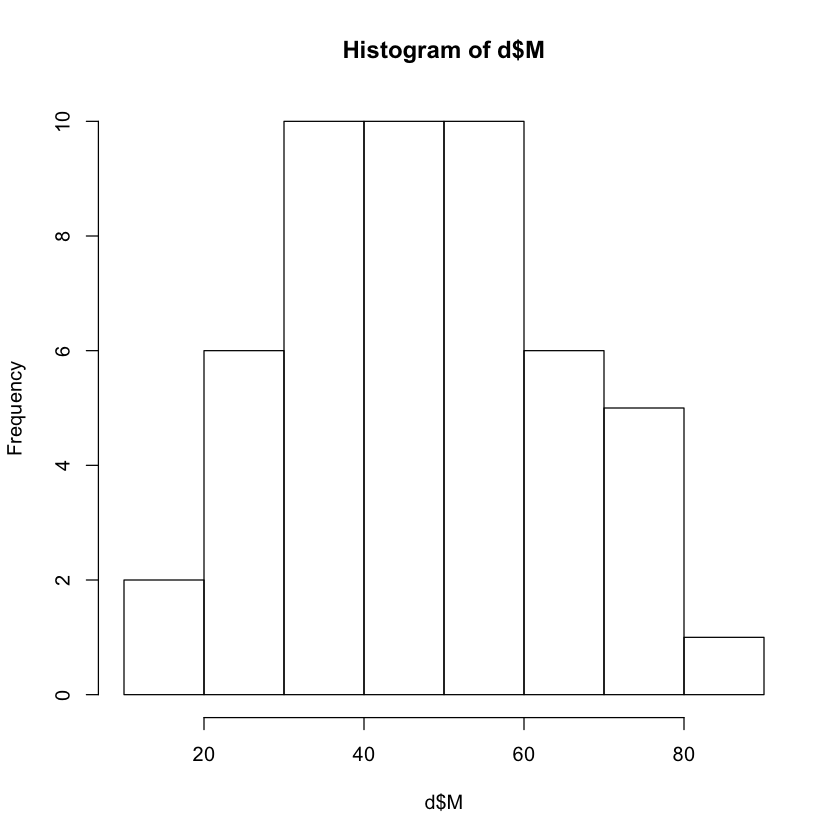

In [69]:
d <- read.csv(file='input/data-attendance-2.txt')
head(d)
var(d$M)
mean(d$M)
hist(d$M)

In [72]:
# run-model5-6.R
library(rstan)

d <- read.csv(file='input/data-attendance-2.txt')
data <- list(N=nrow(d), A=d$A, Score=d$Score/200, M=d$M)
# fit <- stan(file='model/model5-6.stan', data=data, seed=1234)
fit <- stan(file='model/model5-6b.stan', data=data, seed=1234)

save.image('output/result-model5-6.RData')


SAMPLING FOR MODEL 'model5-6b' NOW (CHAIN 1).

Gradient evaluation took 1.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.12 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 0.143164 seconds (Warm-up)
               0.142532 seconds (Sampling)
               0.285696 seconds (Total)


SAMPLING FOR MODEL 'model5-6b' NOW (CHAIN 2).

Gradient evaluation took 8e-06 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.08 seconds.
Adj

In [71]:
summary(fit)$summary

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
b[1],3.5757790,0.0025824130,0.09474150,3.382711719,3.5140014,3.5762139,3.6388210,3.7606121,1345.951,1.000928
b[2],0.2630198,0.0010085124,0.04274660,0.177981294,0.2351928,0.2624898,0.2918752,0.3492161,1796.555,1.000744
b[3],0.2937357,0.0039612933,0.14819954,0.002940962,0.1961967,0.2913748,0.3941709,0.5928207,1399.651,1.001136
lambda[1],3.6771178,0.0012230487,0.04840531,3.579554541,3.6453739,3.6776726,3.7099442,3.7707516,1566.385,1.000650
lambda[2],4.0517571,0.0007687023,0.03491449,3.983854680,4.0288328,4.0514347,4.0751422,4.1202496,2062.980,1.000567
lambda[3],3.7593638,0.0005695810,0.02834452,3.704614461,3.7400990,3.7601067,3.7784783,3.8138806,2476.438,1.000448
lambda[4],3.9651051,0.0009504971,0.04127339,3.883923659,3.9363375,3.9650325,3.9929673,4.0434387,1885.553,1.000794
lambda[5],4.0708500,0.0009449434,0.04032630,3.992723195,4.0437412,4.0708054,4.0973968,4.1506029,1821.231,1.000694
lambda[6],3.7711132,0.0005910381,0.02940388,3.712760398,3.7513761,3.7712598,3.7907007,3.8287264,2475.018,1.000594
lambda[7],3.7388023,0.0006284996,0.02941887,3.679905254,3.7189277,3.7393724,3.7586334,3.7955818,2190.998,1.000328


---
## 練習問題

### (1)

In [73]:
d <- read.csv(file='input/data-attendance-1.txt')
data <- list(N=nrow(d), A=d$A, Score=d$Score/200, Y=d$Y) # scoreを0-1にnormalize してある
fit <- stan(file='model/model5-3.stan', data=data, seed=1234)

In file included from file2367a622eb5.cpp:8:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/src/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/stan/math.hpp:4:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/stan/math/rev/mat.hpp:4:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/stan/math/rev/core.hpp:12:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/stan/math/rev/core/gevv_vvv_vari.hpp:5:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/stan/math/rev/core/var.hpp:7:
In file included from /usr/local/lib/R/3.4/site-library/BH/include/boost/math/tools/config.hpp:13:
In file included from /usr/local/lib/R/3.4/site-library/BH/include/boost/config.hpp:39:
/usr/local/lib/R/3.4/site-library/BH/include/boost/config/compiler/clang.hpp:200:11: warning: 'BOOST_NO_CXX11_RVALUE_REFERENCES' macro red

In [74]:
summary(fit)$summary

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
b1,0.1237080,0.0007915784,0.032685289,0.05933963,0.10131048,0.1239283,0.14516324,0.18964909,1704.970,1.0032420
b2,-0.1433621,0.0003232118,0.015694059,-0.17505770,-0.15367413,-0.1431573,-0.13317507,-0.11248439,2357.741,1.0001956
b3,0.3240060,0.0012386221,0.051580536,0.22089021,0.28908222,0.3236569,0.35965052,0.42358951,1734.180,1.0025950
sigma,0.0516997,0.0001187241,0.005395079,0.04236225,0.04792176,0.0512334,0.05503906,0.06370667,2064.989,1.0003418
mu[1],0.2354901,0.0003861845,0.016501949,0.20202219,0.22450722,0.2355664,0.24606147,0.26811360,1825.916,1.0032574
mu[2],0.2152503,0.0002593830,0.013154803,0.18944968,0.20638499,0.2150494,0.22406324,0.24096509,2572.086,0.9999335
mu[3],0.3262118,0.0001724294,0.009584921,0.30721138,0.31972165,0.3263144,0.33253059,0.34525928,3089.972,1.0000558
mu[4],0.1196685,0.0003122104,0.015220434,0.08916001,0.10962018,0.1195094,0.12964263,0.14919250,2376.617,1.0019151
mu[5],0.2363107,0.0003082096,0.014912782,0.20688353,0.22632444,0.2363880,0.24625088,0.26607367,2341.127,1.0002225
mu[6],0.3391720,0.0001799859,0.010007403,0.31926149,0.33260343,0.3392231,0.34570336,0.35904595,3091.474,0.9996781


In [99]:
ms <- rstan::extract(fit)
noise <- t(d$Y - t(ms$mu))
dim(noise)

[1] 4000   50

### (2)
q2.stan

### (3)

In [109]:
d <- read.csv(file="input/data-attendance-3.txt")
d %>% head

PersonID,A,Score,Weather,Y
1,0,69,B,1
1,0,69,A,1
1,0,69,C,1
1,0,69,A,1
1,0,69,B,1
1,0,69,B,1


In [114]:
d %>% dplyr::filter(A==0) %>% dplyr::filter(Y==1) %>% dim
d %>% dplyr::filter(A==0) %>% dplyr::filter(Y==0) %>% dim
d %>% dplyr::filter(A==1) %>% dplyr::filter(Y==1) %>% dim
d %>% dplyr::filter(A==1) %>% dplyr::filter(Y==0) %>% dim

[1] 994   5

[1] 288   5

[1] 728   5

[1] 386   5

### (4)
q4.stan

In [133]:
conv[d$Weather]

B A C A B B C B A A A C A A A A A B A A B B C C A A B A B A B A B A C A A A B A 
2 1 3 1 2 2 3 2 1 1 1 3 1 1 1 1 1 2 1 1 2 2 3 3 1 1 2 1 2 1 2 1 2 1 3 1 1 1 2 1 
A B B A A A C A B B B B A A A A A C A C A A A A B A B C B C C A B A B C A A C B 
1 2 2 1 1 1 3 1 2 2 2 2 1 1 1 1 1 3 1 3 1 1 1 1 2 1 2 3 2 3 3 1 2 1 2 3 1 1 3 2 
B C B A A A A B A A B A A B B B A A C A A C B B A A A C A A A B B C B A C A C B 
2 3 2 1 1 1 1 2 1 1 2 1 1 2 2 2 1 1 3 1 1 3 2 2 1 1 1 3 1 1 1 2 2 3 2 1 3 1 3 2 
B A A A B A B B A A C A A A B B C A A C A A A A A B A A C B B B C B C A A C A B 
2 1 1 1 2 1 2 2 1 1 3 1 1 1 2 2 3 1 1 3 1 1 1 1 1 2 1 1 3 2 2 2 3 2 3 1 1 3 1 2 
A C B A A B A A C A C B A A A A C B B C B A A B A A B B B A B A B B A A B A A A 
1 3 2 1 1 2 1 1 3 1 3 2 1 1 1 1 3 2 2 3 2 1 1 2 1 1 2 2 2 1 2 1 2 2 1 1 2 1 1 1 
A A B A C C A B A A A A C A B B C B B C A A A C A A A A A B A A A B A C B A B B 
1 1 2 1 3 3 1 2 1 1 1 1 3 1 2 2 3 2 2 3 1 1 1 3 1 1 1 1 1 2 1 1 1 2 1 3 2 1 2 2 
A A B C B C A A B C A A A A A A C C B B A A A B B A B A C C A B B C A A C A B A 
1 1 2 3 2 3 1 1 2 3 1 1 1 1 1 1 3 3 2 2 1 1 1 2 2 1 2 1 3 3 1 2 2 3 1 1 3 1 2 1 
A B A B A A B C B A B B C B C A A C A B A B C B A A A A A B A B A C B C A A A B 
1 2 1 2 1 1 2 3 2 1 2 2 3 2 3 1 1 3 1 2 1 2 3 2 1 1 1 1 1 2 1 2 1 3 2 3 1 1 1 2 
A A C A A B B B C B C A A A A C A A A A C A A A A B A A A A B A B C B B B B C A 
1 1 3 1 1 2 2 2 3 2 3 1 1 1 1 3 1 1 1 1 3 1 1 1 1 2 1 1 1 1 2 1 2 3 2 2 2 2 3 1 
B A C A A C B A A B A A C B A A A B A A A C A C B A B B A B A A A C A B A A C A 
2 1 3 1 1 3 2 1 1 2 1 1 3 2 1 1 1 2 1 1 1 3 1 3 2 1 2 2 1 2 1 1 1 3 1 2 1 1 3 1 
A A B B B B C B C A A A A A A B C A A A A A B A A B B A A B B B B A C B A B A B 
1 1 2 2 2 2 3 2 3 1 1 1 1 1 1 2 3 1 1 1 1 1 2 1 1 2 2 1 1 2 2 2 2 1 3 2 1 2 1 2 
A B B A A A B A A A A A A A A A B A C A C B A A C B A B A A A C A B A A A B B C 
1 2 2 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 3 1 3 2 1 1 3 2 1 2 1 1 1 3 1 2 1 1 1 2 2 3 
C C A A A A C A A A B A A A A B A B A A A C B B B B A A C C A C C A A A A B B C 
3 3 1 1 1 1 3 1 1 1 2 1 1 1 1 2 1 2 1 1 1 3 2 2 2 2 1 1 3 3 1 3 3 1 1 1 1 2 2 3 
A A A A C C B B A A B B A A A C C A A A B B A A C A A A A A B C B B C C A A C B 
1 1 1 1 3 3 2 2 1 1 2 2 1 1 1 3 3 1 1 1 2 2 1 1 3 1 1 1 1 1 2 3 2 2 3 3 1 1 3 2 
C B A B A C A B A A A A A B B C B A A B C A A B A B A B A A B A A C C B B A C A 
3 2 1 2 1 3 1 2 1 1 1 1 1 2 2 3 2 1 1 2 3 1 1 2 1 2 1 2 1 1 2 1 1 3 3 2 2 1 3 1 
A A B C B B A A B C B A A C C B A A B B C B C A A A A C A C A A A A A A B B A A 
1 1 2 3 2 2 1 1 2 3 2 1 1 3 3 2 1 1 2 2 3 2 3 1 1 1 1 3 1 3 1 1 1 1 1 1 2 2 1 1 
A B C A A C A C A B A C B C A A B C B B A A B B B A C C B A B C C C A A A A A A 
1 2 3 1 1 3 1 3 1 2 1 3 2 3 1 1 2 3 2 2 1 1 2 2 2 1 3 3 2 1 2 3 3 3 1 1 1 1 1 1 
B A B A A A B B B A A C C A A A A B C A A C C B A B A C A A A A B B C B B A A A 
2 1 2 1 1 1 2 2 2 1 1 3 3 1 1 1 1 2 3 1 1 3 3 2 1 2 1 3 1 1 1 1 2 2 3 2 2 1 1 1 
B C A A B A B A B A A A B A C B A A B C C B B A C A A A A A B C B B A A A B C B 
2 3 1 1 2 1 2 1 2 1 1 1 2 1 3 2 1 1 2 3 3 2 2 1 3 1 1 1 1 1 2 3 2 2 1 1 1 2 3 2 
A A C C B A A A A B B B B C A A A C A A A B A A A B A B B A A B B B A C C A B A 
1 1 3 3 2 1 1 1 1 2 2 2 2 3 1 1 1 3 1 1 1 2 1 1 1 2 1 2 2 1 1 2 2 2 1 3 3 1 2 1 
B A A B B A C A A A A A A B B C A A B C A A A A A A B B B A A A B C A B A B A B 
2 1 1 2 2 1 3 1 1 1 1 1 1 2 2 3 1 1 2 3 1 1 1 1 1 1 2 2 2 1 1 1 2 3 1 2 1 2 1 2 
A C B A B B A A A A A A B B A A C B A A C B A A A A A B B B C A A A A A A C A A 
1 3 2 1 2 2 1 1 1 1 1 1 2 2 1 1 3 2 1 1 3 2 1 1 1 1 1 2 2 2 3 1 1 1 1 1 1 3 1 1 
A B A A B B C A B A B A A A A A C A B A A B A A C A A C B B C A B A A B A B A A 
1 2 1 1 2 2 3 1 2 1 2 1 1 1 1 1 3 1 2 1 1 2 1 1 3 1 1 3 2 2 3 1 2 1 1 2 1 2 1 1 
B B C B A B B A B C A C B A A B B A A A A A B A A C C A B A A A A A A A B B C B 
2 2 3 2 1 2 2 1 2 3 1 3 2 1 1 2 2 1 1 1 1 1 2 1 1 3 3 1 2 1 1 1 1 1 1 1 2 2 3 2 
B C A A A A A C A C A A A A B A A B A A A A C B C B C B B A A B C C A A C C A B 
2 3 1 1 1 1 1 3 1 3 1 1 1 1 2 1

In [125]:
d <- read.csv(file='input/data-attendance-3.txt')
# A, B, Cを1, 2, 3に変換した上でStanに渡す
conv <- c(1, 2, 3)
names(conv) <- c('A', 'B', 'C')
data <- list(I=nrow(d), A=d$A, Score=d$Score/200, WID=conv[d$Weather], Y=d$Y)
fit <- stan(file='model/q4.stan', data=data, seed=1234)

SYNTAX ERROR, MESSAGE(S) FROM PARSER:

ERROR:  Container index must be integer; found type=real
  error in 'model2364050aeea_q4' at line 25, column 60
  -------------------------------------------------
    23:   
    24:   for (i in 1:I)
    25:     q[i] = inv_logit(b[1] + b[2]*A[i] + b[3]*Score[i] + bw[WID[i]]);
                                                                   ^
    26: 
  -------------------------------------------------

PARSER EXPECTED: <one or more container indexes followed by ']'>


ERROR: Error in stanc(file = file, model_code = model_code, model_name = model_name, : failed to parse Stan model 'q4' due to the above error.
